In [200]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.covariance import corr_to_cov_matrix

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks, calculate_risk_contributions, calculate_marginal_sharpe

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modern Portfolio Theory 

[Modern portfolio theory or mean-variance optimization](https://en.wikipedia.org/wiki/Modern_portfolio_theory) dates back to Harry Markowitz in the 1950s and revolutionized investors approach to investing and diversification. Markowitz's approach made it clear that diversification is a key when evaluating a given investment given the universe of investable assets. Furthermore, it is not only the number of assets that determine the level of diversification but also the dependence between assets. The particular method suggested by Markowitz has it flaws but stands as the foundation for all the innovations we have seen during the last 50 years. 

## Introduction 

### The basic problem 

One way to look at the mean-variance framework is to maximize the expected quadratic utility (we could also minimize variance for a given return target)

$$
U(\mathbf{w}) = \mathbf{w}^\top \boldsymbol{\mu} - \frac{1}{2 \lambda} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

where $\mathbf{w}$ denotes the portfolio weights ($N \times 1$ vector), $\boldsymbol{\mu}$ expected return vector ($N \times 1$ vector) and $\boldsymbol{\Sigma}$ the covariance matrix ($N \times N$ matrix). $\lambda$ is linked to the risk aversion. 

The FOCs (setting the derivative wrt. to $\mathbf{w}$ equal to zero) are given by 

$$
\left. \frac{\partial U(\mathbf{w})}{\partial \mathbf{w}} \right \vert_{\mathbf{w}= \mathbf{w}^*} = \boldsymbol{\mu} - \frac{1}{\lambda} \boldsymbol{\Sigma} \mathbf{w}^* = \mathbf{0}
$$

resulting in the solution 

$$
\mathbf{w}^* = \lambda \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} 
$$

The above case is of course unrealistic in practice since investor probably would like to impose different constraints. Adding linear constraints covers many relevant constraints. 

### Adding linear constraints

The mean-variance optimization with linear constraints can be written  as 

$$
\underset{\mathbf{w}}{\text{arg max }} U(\mathbf{w}) = \underset{\mathbf{w}}{\text{arg max }} \mathbf{w}^\top \boldsymbol{\mu} - \frac{1}{2 \lambda} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the $M$ constraints

$$
\mathbf{A} \mathbf{w} = \mathbf{b}
$$

where $\mathbf{A}$ is a ($M \times N$ matrix) and $\mathbf{b}$ is a ($M \times 1$ vector). 

The Lagrangian for this problem can be written as

$$
\mathcal{L} = U(\mathbf{w}) - \boldsymbol{\gamma} (\mathbf{A} \mathbf{w} - \mathbf{b})
$$

The objective is then to maximize the Lagrangian. The solution to this maximization problem is given by (see e.g. [Rebonato and Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117))

$$
\mathbf{w}^* = \lambda \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - \lambda \boldsymbol{\Sigma}^{-1} \mathbf{A}^\top \mathbf{C}^{-1} \left(\mathbf{A}\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}  - \frac{1}{\lambda} \mathbf{b} \right)
$$

with $\mathbf{C} = \mathbf{A} \boldsymbol{\Sigma}^{-1}\mathbf{A}^\top$.

__The budget constraint__

We will typically add a budget constraint stating that the amount invested should be equal to a certain amount (typically normalized to $1$ dollar such that we can interpret the portfolio weights as the proportion invested in the assets)

$$
\sum_{i=1}^N w_i = \mathbf{1}^\top \mathbf{w} = 1
$$

This particular constraint can be implemented using the above formula with $\mathbf{A} = \mathbf{1}^\top$ and $\mathbf{b} = 1$.

__Expected return target__

We may assume that the investor target a particular return 

$$
\sum_{i=1}^N w_i \mu_i = \boldsymbol{\mu}^\top \mathbf{w} = \bar{\mu}_p
$$

Thus,  $\mathbf{A} = \boldsymbol{\mu}^\top$ and $\mathbf{b} = \bar{\mu}_p$.

## Alternative specifictions 

An alternative way of looking the mean-variance problem is to minimize variance for a given return target: 

$$
\underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint and a return target

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mathbf{w}^\top \boldsymbol{\mu} &= \bar{\mu}_p
\end{align}
$$

Yet another approach is to maximize expected return given a risk target: 

$$
\underset{\mathbf{w}}{\text{arg max }} \mathbf{w}^\top \mu
$$

subject to the budget constraint and a variance target

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w} &= \bar{\sigma}_p^2
\end{align}
$$


## Some important portfolios

### The (global) minimum variance portfolio

The minimum variance portfolio is the solution to the below problem. 

$$
\underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constrain

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\end{align}
$$

Note that we also could have maximize the quadratic utility assuming that $\lambda \to 0$. 

The solution to the above problem can be found by defining the Lagrangian, finding the FOCs and solving the FOCs. One can show that the solution to this problem is given by

$$
\mathbf{w} = \frac{\boldsymbol{\Sigma}^{-1} \mathbf{1}}{\mathbf{1}^\top \boldsymbol{\Sigma}^{-1} \mathbf{1}}
$$

### Efficient portfolios 

We could specify the mean-variance problem as 

$$
\underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint and a return target

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mathbf{w}^\top \boldsymbol{\mu} &= \bar{\mu}_p
\end{align}
$$

The corresponding Lagrangian is given by

$$
\mathcal{L}(\mathbf{w}, \gamma_1, \gamma_2) = \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w} + \gamma_1 \left(\mathbf{w}^\top \boldsymbol{\mu} - \bar{\mu}_p\right) + \gamma_2 \left(\mathbf{w}^\top \mathbf{1} -1 \right)
$$

The first order conditions are given by 

$$
\begin{align}
\frac{\partial \mathcal{L}(\mathbf{w}, \gamma_1, \gamma_2)}{\partial \mathbf{w}} &= 2  \boldsymbol{\Sigma} \mathbf{w} + \gamma_1 \boldsymbol{\mu} +   \gamma_2 \mathbf{1} = \mathbf{0} \\
\frac{\partial \mathcal{L}(\mathbf{w}, \gamma_1, \gamma_2)}{\partial \gamma_1} &= \mathbf{w}^\top \boldsymbol{\mu} - \bar{\mu}_p = 0 \\
\frac{\partial \mathcal{L}(\mathbf{w}, \gamma_1, \gamma_2)}{\partial \gamma_2} &= \mathbf{w}^\top \mathbf{1} -1 = 0
\end{align}
$$

We can alternatively write this as a system of linear equations 

$$
\mathbf{A} \mathbf{x} = \mathbf{b}
$$

with 

$$
\mathbf{A} = \begin{bmatrix}
2  \boldsymbol{\Sigma} & \boldsymbol{\mu} & \mathbf{1} \\
\boldsymbol{\mu}^\top & 0 & 0 \\
\mathbf{1}^\top & 0 & 0\end{bmatrix}
$$

and 

$$
\mathbf{x} = \begin{bmatrix}
\mathbf{w} \\
\gamma_1 \\
\gamma_2 \end{bmatrix}
$$

and 

$$
\mathbf{b} = \begin{bmatrix}
\mathbf{0} \\
 \bar{\mu}_p \\
1 \end{bmatrix}
$$

We can easily solve this system of equations

$$
\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}
$$

We will call the solution (the first $N$ elements of the vector $\mathbf{x}$) an efficient portfolio if the expected return is equal to or larger than the return of the minimum variance portfolio. 


### The efficient frontier

The [seperation theorem](https://en.wikipedia.org/wiki/Mutual_fund_separation_theorem) tells us that any efficient portfolio (minimum variance portfolio for a given target return) defined by the portfolio weights $\mathbf{w}_c$ can be obtained as a linear combination of two other efficient portfolios defined by the portfolio weights $\mathbf{w}_a$ and $\mathbf{w}_b$

$$
\mathbf{w}_c = \alpha \mathbf{w}_a + (1-\alpha) \mathbf{w}_b
$$

Thus, we only need to find two efficient portfolios to draw the entire efficient frontier!


### The tangency portfolio 

The tangency portfolio is the portfolio of risky assets with highest Sharpe ratio. Assume the existence of a risk free asset with return $r_f$. The optimization problem then reads


$$
\underset{\mathbf{w}}{\text{arg max }} \frac{\mathbf{w}^\top \boldsymbol{\mu} - r_f}{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \frac{\mu_p - r_f}{\sigma_p}
$$

subject to the budget constraint $\mathbf{w}^\top \mathbf{1} = 1$. After setting up the Lagrangian and a lot of tedious calculations, then it is possible to show that the solution to the above problem is given by

$$
\mathbf{w}^* = \frac{\boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu} - r_f \mathbf{1})}{\mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu} - r_f \mathbf{1})}
$$



### Example: Three risky assets 

In [29]:
"""
Define relevant quantities
"""
corr = np.array([[1.0, 0.9, 0.7],
                 [0.9, 1.0, 0.4],
                 [0.7, 0.4, 1.0]])


vols = np.array([0.2, 0.15, 0.1])

rf = 0.0 # assume that the risk free rate is zero 
mu = vols * 0.2 # constant Sharpe ratio

# transform to covariance matrix using previously defined function (imported at the top of the notebook)
cov_mat = corr_to_cov_matrix(corr, vols)


In [30]:
"""
Define functions used to calculate portfolios
"""

def minimum_variance_portfolio(cov_mat: np.ndarray) -> np.ndarray:
    
    """
    Calculates the minimum-variance portfolio weights. 
    
    Parameters
    ----------
    cov_mat:
        The covariance matrix. 

    Returns
    -------
    np.ndarray
        Minimum variance portfolio weights. 

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)
    
    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_min_var = cov_mat_inv @ vec_ones / (vec_ones @ cov_mat_inv @ vec_ones)
    
    return w_min_var


def tangency_portfolio(cov_mat: np.ndarray, mu: np.ndarray, rf: float) -> np.ndarray:
    
    """
    Calculates the maximum sharpe ratio portfolio weights.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.
    mu: 
        Expected return vector. 
    rf: 
        The risk free rate. 

    Returns
    -------
    np.ndarray
        maximum sharpe ratio portfolio weights.

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_max_sr = cov_mat_inv @ excess_mu / (vec_ones @ cov_mat_inv @ excess_mu)
    
    return w_max_sr

In [31]:
# minimum variance portfolio 
w_mv = minimum_variance_portfolio(cov_mat=cov_mat)

mu_mv = portfolio_mean(w_mv, mu)
std_mv = portfolio_std(w_mv, cov_mat)

# tangency portfolio 
w_max_sr = tangency_portfolio(cov_mat=cov_mat, mu=mu, rf=rf)

mu_max_sr = portfolio_mean(w_max_sr, mu)
std_max_sr = portfolio_std(w_max_sr, cov_mat)

# efficient portfolios
alpha = np.linspace(-5.0, 1.0, 1000)

w_eff = w_mv[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, (cov_mat))
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, (mu))

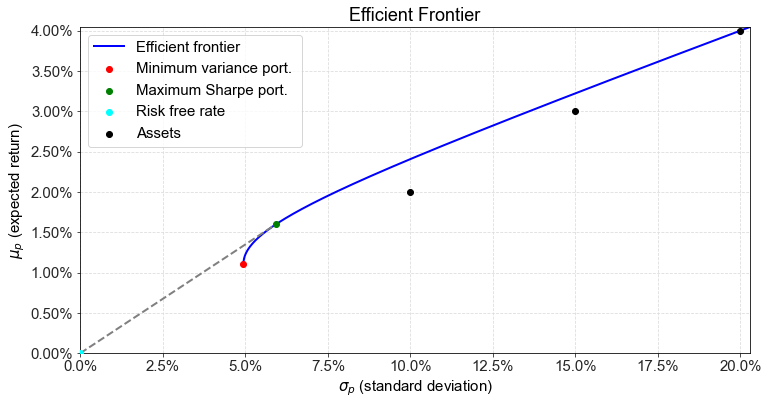

In [32]:
"""
Plot the efficient frontier
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient frontier")
ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_mv, mu_mv, color="red", label="Minimum variance port. ", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="Maximum Sharpe port. ", zorder=10)
ax.scatter(0, rf, color="cyan", label="Risk free rate", zorder=10)
ax.scatter(vols, mu, color="black", label="Assets", zorder=10)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.set_title("Efficient Frontier")
ax.set_xlabel("$\sigma_p$ (standard deviation)")
ax.set_ylabel("$\mu_p$ (expected return)")

ax.legend();

### Equal risk contribution 

In the first week, we talked about risk contribution. We showed that we could write the portfolio standard deviation as 

$$
\sigma_p(\mathbf{w}) = \mathbf{w}^\top \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \sum_{i=1}^N w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \sum_{i=1}^N w_i \text{MR}_i = \sum_{i=1}^N \text{RC}_i
$$

where $\text{MR}_i = \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}$ is the marginal risk of asset $i$ and $\text{RC}_i$ is the risk contribution of asset $i$. 

There is a large literature on *risk parity investing* where the focus is on allocating risk instead of capital, e.g. we want an equal amount of risk coming from bonds and stocks. The problem that we want to solve is 

$$
w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = b_i  \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

where $b_i$ is the risk coming from the $i$'th asset. In addition, we would likely impose positivity contraints $b_i \geq 0, w_i \geq 0$, weights summing to one $\sum_{i=1}^N w_i = 1$, and $\sum_{i=1}^N b_i = 1$. 

Generally, we need numerical methods for solving the problem when dealing with more than two assets. However, [Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778) present an exact solution for the two asset case


In [33]:
def weights_risk_budget_two_assets(sigma1: float, sigma2: float, rho: float, b: float) -> Tuple[float, float]:
    """
    Function that calculates the portfolio weights that result in equal risk contribution. Two asset case.

    Parameters
    ----------
    sigma1:
        Std. of asset 1
    sigma2:
        Std. of asset 2
    rho:
        Correlation between asset 1 and asset 2
    b:
        Risk contribution from asset 1

    Returns
    -------
    np.ndarray
       Optimal weights.

    """

    num = (b - 0.5) * rho * sigma1 * sigma2 - b * sigma2 ** 2 + sigma1 * sigma2 * np.sqrt(
        (b - 0.5) ** 2 * rho ** 2 + b * (1 - b))
    den = (1 - b) * sigma1 ** 2 - b * sigma2 ** 2 + 2 * (b - 0.5) * rho * sigma1 * sigma2

    w_opt = num / den

    return w_opt, 1 - w_opt

### Comparing the portfolios: The two asset case 

Consider a two asset example with stocks (S) and bonds (B). Stocks are defined by $\mu_S = 0.025, \sigma_S = 0.15$ and bonds are defined by $\mu_B = 0.01, \sigma_B = 0.075$. The correlation between stocks and bonds is $\rho _{S,B} = 0.2$. 

What is the diversification benefits with an equal allocation to stocks and bonds? What changes if we allocate towards an equal risk contribution?

In [34]:
"""
Define the two asset universe
"""
rf = 0.0
sigma1 = 0.15
sigma2 = 0.075
rho=0.2
b = 0.5

vols = np.array([sigma1, sigma2])
corr_mat = np.array([[1.0, rho], [rho, 1.0]])
cov_mat = np.outer(vols, vols)*corr_mat

mu = np.array([0.025, 0.01])

"""
Equal weigths vs. equal risk weights
"""

# equal weights
eq_weight = np.array([0.5, 0.5])

# equal risk weigths 
eq_risk_weight = np.array(weights_risk_budget_two_assets(sigma1, sigma2, rho, b))

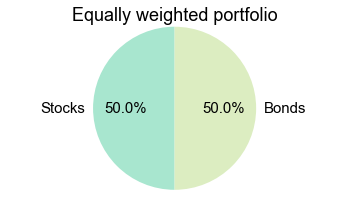

In [35]:
fig, ax = plt.subplots(figsize=(6, 3))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Stocks', 'Bonds'
sizes = [50, 50]

ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, textprops={'color': 'black', 'size': 15})
ax.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Equally weighted portfolio");

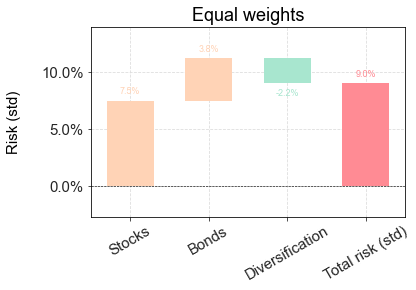

In [36]:
total_risk_eq_w  = portfolio_std(eq_weight, cov_mat)


fig, ax = risk_waterfall_chart(vols * eq_weight * 100, total_risk_eq_w*100, names=["Stocks", "Bonds"],
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)",
                               diversification_label="Diversification", title="Equal weights", ylabel="Risk (std)");

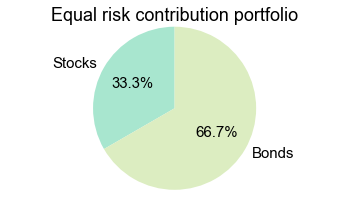

In [37]:
sizes = eq_risk_weight*100

fig, ax = plt.subplots(figsize=(6, 3))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, textprops={'color': 'black', 'size': 15})
ax.axis('equal') 
ax.set_title("Equal risk contribution portfolio");

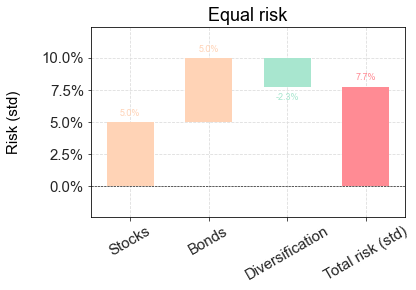

In [38]:
total_risk_eq_risk_w  = portfolio_std(eq_risk_weight, cov_mat)


fig, ax = risk_waterfall_chart(vols * eq_risk_weight * 100, total_risk_eq_risk_w*100, names=["Stocks", "Bonds"],
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)",
                               diversification_label="Diversification", title="Equal risk", ylabel="Risk (std)");

In [39]:
# minimum variance portfolio 
w_mv = minimum_variance_portfolio(cov_mat=cov_mat)

mu_mv = portfolio_mean(w_mv, mu)
std_mv = portfolio_std(w_mv, cov_mat)
mr_mv = calculate_marginal_risks(w_mv, cov_mat)
m_sharpe_mv = calculate_marginal_sharpe(w_mv, cov_mat, mu, rf)

# tangency portfolio 
w_max_sr = tangency_portfolio(cov_mat=cov_mat, mu=mu, rf=rf)

mu_max_sr = portfolio_mean(w_max_sr, mu)
std_max_sr = portfolio_std(w_max_sr, cov_mat)
mr_max_sr = calculate_marginal_risks(w_max_sr, cov_mat)
m_sharpe_max_sr = calculate_marginal_sharpe(w_max_sr, cov_mat, mu, rf)

# equal weight port. 
mu_eq = portfolio_mean(eq_weight, mu)
std_eq = portfolio_std(eq_weight, cov_mat)
mr_eq = calculate_marginal_risks(eq_weight, cov_mat)
m_sharpe_eq = calculate_marginal_sharpe(eq_weight, cov_mat, mu, rf)


# equal risk contrib. port
mu_eq_risk = portfolio_mean(eq_risk_weight, mu)
std_eq_risk = portfolio_std(eq_risk_weight, cov_mat)
mr_eq_risk = calculate_marginal_risks(eq_risk_weight, cov_mat)
m_sharpe_eq_risk = calculate_marginal_sharpe(eq_risk_weight, cov_mat, mu, rf)

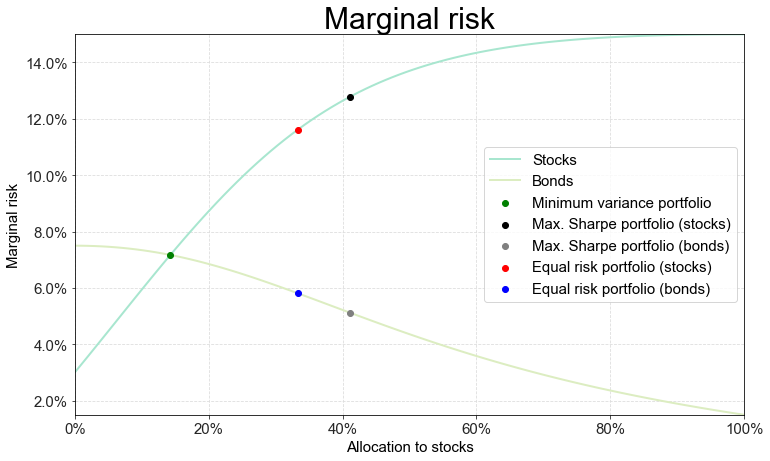

In [40]:
w_to_apply = np.linspace(0.0, 1.0, 100)
w_to_apply = np.c_[w_to_apply, 1-w_to_apply].T

"""
The minimum variance portfolio ensures equal marginal risk 
"""

mr = np.apply_along_axis(calculate_marginal_risks, 0, w_to_apply, (cov_mat))


fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(w_to_apply[0, :], mr[0, :], label="Stocks")
ax.plot(w_to_apply[0, :], mr[1, :], label="Bonds")

# minimum variance
ax.scatter(w_mv[0], mr_mv[0], label="Minimum variance portfolio",
            color= "green", zorder=10)

# tangency portfolio
ax.scatter(w_max_sr[0], mr_max_sr[0], label="Max. Sharpe portfolio (stocks)",
            color= "black", zorder=10)

ax.scatter(w_max_sr[0], mr_max_sr[1], label="Max. Sharpe portfolio (bonds)",
            color= "gray", zorder=10)

# equal risk budget
ax.scatter(eq_risk_weight[0], mr_eq_risk[0], label="Equal risk portfolio (stocks)",
            color= "red", zorder=10)

ax.scatter(eq_risk_weight[0], mr_eq_risk[1], label="Equal risk portfolio (bonds)",
            color= "blue", zorder=10)


ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title("Marginal risk", size=30)

plt.xlabel('Allocation to stocks', size=15)
plt.ylabel('Marginal risk', size=15);

plt.legend(fontsize=15);

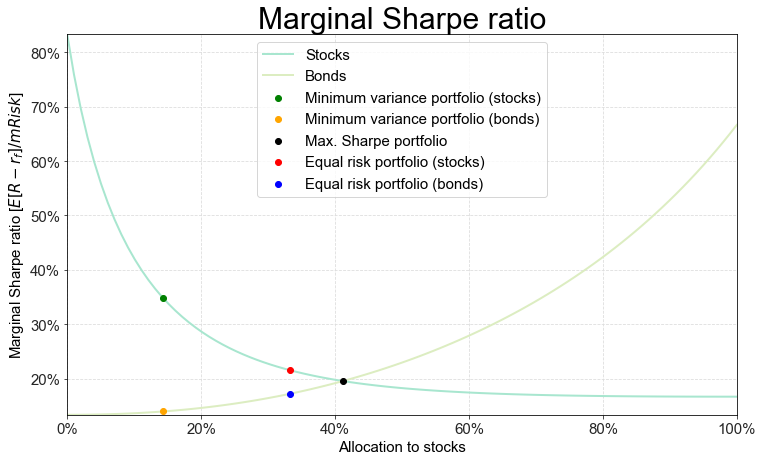

In [41]:
"""
The tangency portfolio ensures equal marginal Sharpe ratio
"""

m_sharpe = np.apply_along_axis(calculate_marginal_sharpe, 0, w_to_apply, cov_mat, mu, rf)


fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(w_to_apply[0, :], m_sharpe[0, :], label="Stocks")
ax.plot(w_to_apply[0, :], m_sharpe[1, :], label="Bonds")

# minimum variance
ax.scatter(w_mv[0], m_sharpe_mv[0], label="Minimum variance portfolio (stocks)",
            color= "green", zorder=10)

ax.scatter(w_mv[0], m_sharpe_mv[1], label="Minimum variance portfolio (bonds)",
            color= "orange", zorder=10)

# tangency portfolio
ax.scatter(w_max_sr[0], m_sharpe_max_sr[0], label="Max. Sharpe portfolio",
            color= "black", zorder=10)

# equal risk budget
ax.scatter(eq_risk_weight[0], m_sharpe_eq_risk[0], label="Equal risk portfolio (stocks)",
            color= "red", zorder=10)

ax.scatter(eq_risk_weight[0], m_sharpe_eq_risk[1], label="Equal risk portfolio (bonds)",
            color= "blue", zorder=10)


ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title("Marginal Sharpe ratio", size=30)

plt.xlabel('Allocation to stocks', size=15)
plt.ylabel('Marginal Sharpe ratio [$E[R - r_f]/mRisk$]', size=15);

plt.legend(fontsize=15);

### Inequality constraints 

Above, we have only looked at problems with an analytical solution. In other cases, we do not have an analytical solution why we need apply numerical methods to solve the optimization problem. 

If we add a no short selling constraint, the mean-variance problem can be written as: 

$$
\underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint, a return target and positivity constriants

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mathbf{w}^\top \boldsymbol{\mu} &= \bar{\mu}_p \\
w_i &\geq 0, \; i=1,..., N
\end{align}
$$

There is no analytical solution to this problem, but we can easily solve it using `scipy.optimize.minimize`. 

In [42]:
"""
Define relevant quantities
"""
corr = np.array([[1.0, 0.9, 0.7],
                 [0.9, 1.0, 0.4],
                 [0.7, 0.4, 1.0]])


vols = np.array([0.2, 0.15, 0.1])

rf = 0.0 # assume that the risk free rate is zero 
mu = vols * 0.2 # constant Sharpe ratio

# transform to covariance matrix using previously defined function (imported at the top of the notebook)
cov_mat = corr_to_cov_matrix(corr, vols)

In [43]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu)

# define constraint 
target_cons = {'type': 'eq',
               'fun' : lambda x: x @ mu - 0.025,
               'jac' : lambda x: mu}

port_var_der = lambda w, cov_mat: 2 * w @ cov_mat


x0 = np.ones_like(mu) / len(mu)
res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                        method='SLSQP',
                        jac=port_var_der,
                        constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                        options={'ftol': 1e-9, 'disp': True}) #, bounds=bounds)

w_opt = res.x

res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.011125000000000003
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6


     fun: 0.011125000000000003
     jac: array([0.041 , 0.0285, 0.016 ])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.94289029e-16, 5.00000000e-01, 5.00000000e-01])

In [44]:
"""
Repeat calculations
"""

# minimum variance portfolio 
w_mv = minimum_variance_portfolio(cov_mat=cov_mat)

mu_mv = portfolio_mean(w_mv, mu)
std_mv = portfolio_std(w_mv, cov_mat)

# tangency portfolio 
w_max_sr = tangency_portfolio(cov_mat=cov_mat, mu=mu, rf=rf)

mu_max_sr = portfolio_mean(w_max_sr, mu)
std_max_sr = portfolio_std(w_max_sr, cov_mat)

# opt port with no shorting
mu_no_short = portfolio_mean(w_opt, mu)
std_no_short = portfolio_std(w_opt, cov_mat)

# efficient portfolios
alpha = np.linspace(-5.0, 1.0, 1000)

w_eff = w_mv[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, (cov_mat))
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, (mu))

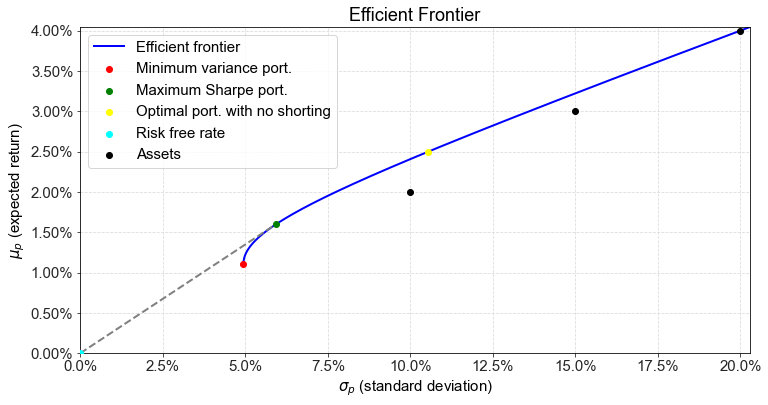

In [45]:
"""
Plot the efficient frontier
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient frontier")
ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_mv, mu_mv, color="red", label="Minimum variance port. ", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="Maximum Sharpe port. ", zorder=10)
ax.scatter(std_no_short, mu_no_short, color="yellow", label="Optimal port. with no shorting", zorder=10)
ax.scatter(0, rf, color="cyan", label="Risk free rate", zorder=10)
ax.scatter(vols, mu, color="black", label="Assets", zorder=10)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.set_title("Efficient Frontier")
ax.set_xlabel("$\sigma_p$ (standard deviation)")
ax.set_ylabel("$\mu_p$ (expected return)")

ax.legend();

## The instability problem 

The optimal solution for the simplest case with no constraint is (see above)

$$
\mathbf{w}^* = \lambda \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} 
$$

The derivative of the optimal portfolio weights wrt. the expected return vector is given by 

$$
\frac{\partial \mathbf{w}^*}{\partial \boldsymbol{\mu}} = \lambda \boldsymbol{\Sigma}^{-1}
$$

We see that the derivative is related to $\lambda$ (that will be related to the risk aversion) and it depends directly on the inverse of the covariance matrix $\boldsymbol{\Sigma}^{-1}$. Since the covariance matrix of returns are given by correlations multiplied with volatilities, the entries of the covariance matrix will be "small" numbers while the entries of the inverse will be "large" numbers. This implies that the sensitivity to changes in the expected returns will be large. Estimation error in the expected returns may be very problematic. 

However, estimation error in expected returns is not the only culprit. From [Riccardo Rebonato and Alexander Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117) 

* The impact of the estimation errors of the covariance matrix can be of the same magnitude as the impact of the estimation error of the mean
* The precision of the optimal portfolio weights estimator computed with the true mean depends on the ratio of the variances and covariances of assets rather than the absolute values
* The stability of optimal portfolio weights computed with the estimated mean deteriorates with the decrease of the eigenvalues of the covariance matrix

The last point echoes the discussion from last week. If the asset universe can be described by a limited number of factor, then a large number of the eigenvalues will be small increasing the instability problem of classical mean-variance optimization. 


### Example

This example is adapted from [Ignazio Basile and Pierpaolo Ferrari (2016), "Asset Management and Institutional Investors"](https://link.springer.com/book/10.1007/978-3-319-32796-9). 

Below we see an example of how small changes in the expected return can change the asset allocation along the efficient frontier!

In [54]:
corr_mat = np.array([[1.0, 0.85, 0.5, 0.45],
                     [0.85, 1.0, 0.5, 0.45],
                     [0.5, 0.5, 1.0, 0.9],
                     [0.45, 0.45, 0.9, 1.0]])

vols = np.array([5.0, 5.0, 22.0, 22.0]) / 100.0
mu_1 = np.array([3.2, 3.12, 8.0, 8.2]) / 100.0
mu_2 = np.array([3.2, 3.22, 8.4, 8.2]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat, vols)

In [52]:
minimum_variance_portfolio(cov_mat)

array([ 0.53892691,  0.53892691, -0.1001686 ,  0.02231479])

In [61]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu)

port_var_der = lambda w, cov_mat: 2 * w @ cov_mat


target_returns = np.linspace(0.035, 0.08, 25)

optimal_port_weights_1 = []
optimal_port_weights_2 = []

x0 = np.ones_like(mu_1) / len(mu_1)

for target_return in target_returns: 
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ mu_1 - target_return,
                   'jac' : lambda x: mu_1}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                            method='SLSQP',
                            jac=port_var_der,
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights_1.append(res.x)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ mu_2 - target_return,
                   'jac' : lambda x: mu_2}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                            method='SLSQP',
                            jac=port_var_der,
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights_2.append(res.x)
    

optimal_port_weights_1 = np.array(optimal_port_weights_1)
optimal_port_weights_2 = np.array(optimal_port_weights_2)

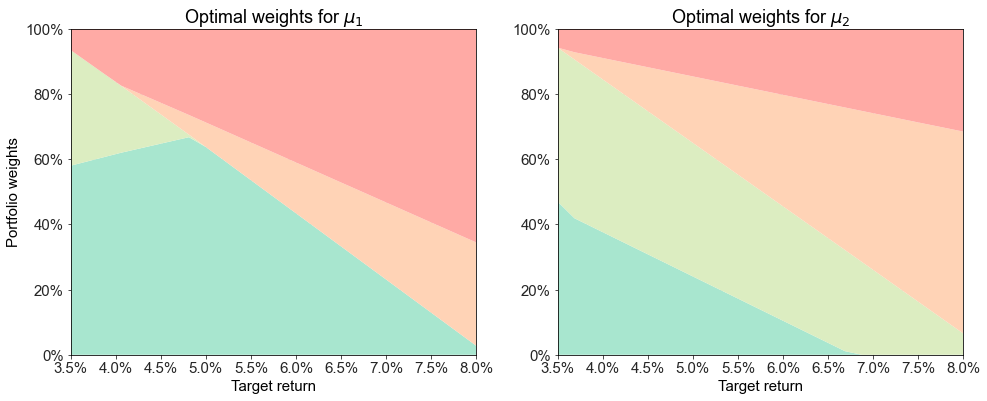

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


ax[0].stackplot(target_returns, optimal_port_weights_1.T);
ax[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax[0].set_xlabel("Target return")
ax[0].set_ylabel("Portfolio weights")
ax[0].set_title("Optimal weights for $\mu_1$")

ax[1].stackplot(target_returns, optimal_port_weights_2.T);
ax[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax[1].set_xlabel("Target return")
#ax[1].set_ylabel("Portfolio weights")
ax[1].set_title("Optimal weights for $\mu_2$");

## A primer to solving the instability problem

The above Markowitz approach does not take estimation error into account thereby treating the input parameters as the only truth. The sensitivity of the solutions to the above problems would not be a problem is we knew with 100\% certainty the input parameters. However, as we have seen previously in the course, estimation errors exist and may be very large. This resulted in the Markowitz approach being labelled as an "error maximizer". We want to explore potential solutions to the instability issue. 

### Shrinkage of the input parameters

As we have previously learned it will be possible to reduce the estimation error of the input parameters by applying different shrinkage estimators. 

### Shrinkage of the portfolios weights

It is often found that the naive $1 / N$ rule outperforms the outperform the (naive) Markowitz approach in empirical analysis. We can think set of fixed portfolio weights as an estimate of the optimal weights with zero variance but with bias (in mean-variance sence).  By shrinking mean-variance weights towards a set of fixed weights (the naive $1 / N$ rule) we may improve the empirical performance. This is the idea of the combination rule of [Tu and Zhou (2011), "Markowitz meets Talmud: A combination of sophisticated and naive diversification strategies"](https://www.sciencedirect.com/science/article/abs/pii/S0304405X10001893). 

### Portfolio constraints

[Jagannathan and Ma (2003)](https://www.jstor.org/stable/3648224) provide evidence for shrinkage type effects of adding weight constraints. 

__Example__

Define the correlation, volatilties, expected returns as below. Assume for simplicity that returns are normally distributed. 

Assume that we have a return target of 5\%. Find the true optimal weights. 

In [71]:
"""
True input parameters
"""

corr_mat = np.array([[1.0, 0.85, 0.5, 0.45],
                     [0.85, 1.0, 0.5, 0.45],
                     [0.5, 0.5, 1.0, 0.9],
                     [0.45, 0.45, 0.9, 1.0]])

vols = np.array([5.0, 5.0, 22.0, 22.0]) / 100.0
mu = np.array([3.2, 3.22, 8.4, 8.2]) / 100.0
rf = 0.0
cov_mat = corr_to_cov_matrix(corr_mat, vols)

"""
True optimal portfolio weights 
"""

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu)

# define constraint 
target_cons = {'type': 'eq',
               'fun' : lambda x: x @ mu - 0.05,
               'jac' : lambda x: mu}

port_var_der = lambda w, cov_mat: 2 * w @ cov_mat


x0 = np.ones_like(mu) / len(mu)
res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                        method='SLSQP',
                        jac=port_var_der,
                        constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                        options={'ftol': 1e-9, 'disp': True}) #, bounds=bounds)

w_opt = res.x

res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0090275933227009
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12


     fun: 0.0090275933227009
     jac: array([0.00663303, 0.00675994, 0.03963037, 0.03836125])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.24028524, 0.4095024 , 0.2037406 , 0.14647177])

Simulate 100 observations from a multivariate normal distribution. Estimate the covariance matrix and mean vector. Calculate the optimal portfolio weights. Repeat this 1000 times. Plot box plot with the optimal portfolio weights.  

In [154]:
num_sim = 1000
num_obs = 100
sim_data = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

mu_est = np.mean(sim_data, axis=1) # num_sim x 4 

opt_port_weights = list()
for i in range(num_sim):
    
    cov_mat_est = np.cov(sim_data[i], rowvar=False)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ mu_est[i] - 0.05,
                   'jac' : lambda x: mu_est[i]}

    port_var_der = lambda w, cov_mat_est: 2 * w @ cov_mat_est


    x0 = np.ones_like(mu) / len(mu)
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_est,),
                            method='SLSQP',
                            jac=port_var_der,
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)
    
    opt_port_weights.append(res.x)
    
    
opt_port_weights = np.array(opt_port_weights)

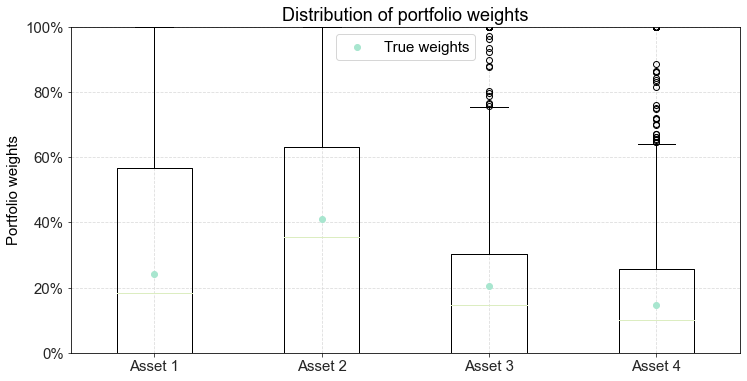

In [155]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(opt_port_weights); 

ax.set_xticklabels(["Asset {}".format(_) for _ in range(1, 5)])
ax.scatter(np.arange(1, 5), w_opt, label="True weights")

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.legend();
ax.set_ylabel("Portfolio weights")
ax.set_title("Distribution of portfolio weights");

Repeat the calculations when weights are constrained between 0.15 and 0.45. 

In [156]:
opt_port_weights_constraints = list()
for i in range(num_sim):
    
    cov_mat_est = np.cov(sim_data[i], rowvar=False)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ mu_est[i] - 0.05,
                   'jac' : lambda x: mu_est[i]}

    port_var_der = lambda w, cov_mat_est: 2 * w @ cov_mat_est

    bounds = [(0.15, 0.45)] * len(mu)
    
    x0 = np.ones_like(mu) / len(mu)
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_est,),
                            method='SLSQP',
                            jac=port_var_der,
                            bounds=bounds,
                            constraints=[sum_to_one_cons, target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)
    
    opt_port_weights_constraints.append(res.x)
    
    
opt_port_weights_constraints = np.array(opt_port_weights_constraints)

C:\environments\python_for_fin_econ\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


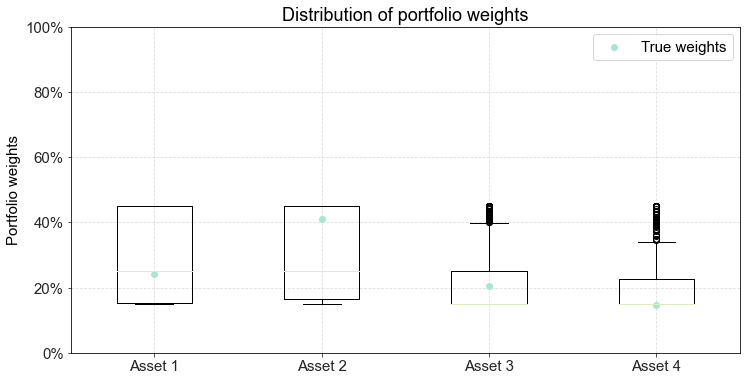

In [187]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(opt_port_weights_constraints); 

ax.set_xticklabels(["Asset {}".format(_) for _ in range(1, 5)])
ax.scatter(np.arange(1, 5), w_opt, label="True weights")

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_ylim([0, 1.0])
ax.legend();
ax.set_ylabel("Portfolio weights")
ax.set_title("Distribution of portfolio weights");

Simulate new data. Apply the constrained and unconstrained portfolio weights. How do they perform "out-of-sample"?

In [195]:
sim_data_new = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

# calculate portfolio returns
return_unconstrained = (sim_data_new[:, :, :] * opt_port_weights[:, None, :]).sum(axis=2)
return_constrained = (sim_data_new[:, :, :] * opt_port_weights_constraints[:, None, :]).sum(axis=2)

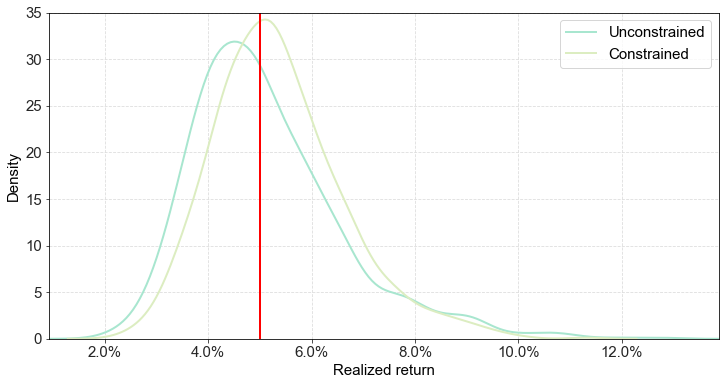

In [196]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(np.mean(return_unconstrained, axis=1), label="Unconstrained");
sns.kdeplot(np.mean(return_constrained, axis=1), label="Constrained");
ax.plot([0.05, 0.05], [0, 35], color="red")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Realized return");
ax.legend();

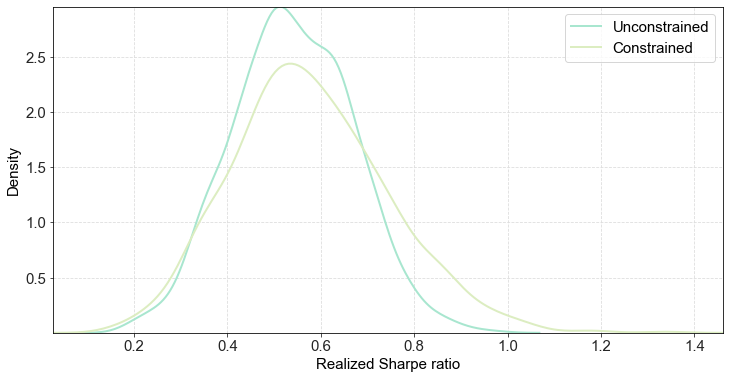

In [197]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(np.mean(return_unconstrained, axis=1) / np.std(return_unconstrained, axis=1), label="Unconstrained")
sns.kdeplot(np.mean(return_constrained, axis=1) / np.std(return_unconstrained, axis=1), label="Constrained")
ax.set_xlabel("Realized Sharpe ratio");
ax.legend();

### The resampling approach

[Michaud (1989)](https://www.jstor.org/stable/4479185) introduced a common approach to "solving" the instability problem known as _resampling_. 

We present a brief describtion of the method (alternative implementations exist). Assume that we have estimated $\boldsymbol{\Sigma}$ and $\boldsymbol{\mu}$ using  $T$ historical return observations, say $\hat{\boldsymbol{\Sigma}}$ and $\hat{\boldsymbol{\mu}}$. 

1. Calculate $M$ efficient portfolios for $M$ different return targets. The return targets span the interval from the return on the minimum-variance portfolio and the maximum return portfolio. Rank the portfolio $m=1, ..., M$. 

2. Resample (simulate) a new data set of lenght $L$ (generally equal to $T$) from a multivariate normal distribution with mean and covariance given by respectively $\hat{\boldsymbol{\mu}}$ and $\hat{\boldsymbol{\Sigma}}$. 

3. Re-estimate the mean and covariance, say $\hat{\boldsymbol{\Sigma}}_{1}$ and $\hat{\boldsymbol{\mu}}_{1}$. 

4. Use the new mean and covariance to determine $M$ efficient portfolios with the same $M$ returns targets as in step 1, label the weights $\mathbf{w}_m^1$

5. Reiterate step 1 to 4 a large number of times, say $H$. 

6. Finally, we can average over the $H$ simulations to obtain the "resampled" weights

$$
\mathbf{w}_{m} = \frac{1}{H} \sum_{h=1}^H \mathbf{w}_m^h
$$

In [201]:
from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets


reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202109 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2021 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (273 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (273 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (22 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (22 rows x 12 cols)\n  4 : Number of Firms in Portfolios (273 rows x 12 cols)\n  5 : Average Firm Size (273 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (23 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (23 rows x 12 cols)'

In [202]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100

# asset list
asset_list = ind_mc_weighted.columns

In [212]:
"""
Last 10Y of data
"""

data = ind_mc_weighted.values[-120:]

"""
Estimate mean and covariance
"""

cov_mat_est = np.cov(data, rowvar=False)
mu_est = np.mean(data, axis=0)

"""
Define mu targts
"""

weight_mv = minimum_variance_portfolio(cov_mat_est)
mu_targets = np.linspace(weight_mv @ mu_est, np.max(mu_est), 10)

In [223]:
"""
Estimate original efficient frontier 
"""

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu_est)
#port_var_der = lambda w, cov_mat_est: 2 * w @ cov_mat_est
optimal_port_weights = []

x0 = np.ones_like(mu_est) / len(mu_est)
for target_return in mu_targets: 
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ mu_est - target_return,
                   'jac' : lambda x: mu_est}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_est,),
                            method='SLSQP',
                            #jac=port_var_der,
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)
    
    optimal_port_weights.append(res.x)

optimal_port_weights = np.array(optimal_port_weights)

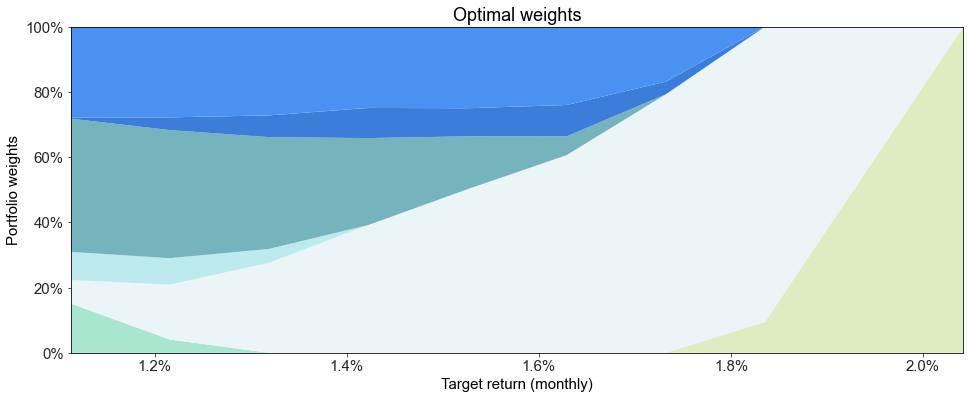

In [224]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(mu_targets, optimal_port_weights.T);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Target return (monthly)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");

In [236]:
optimal_port_resampled_weights = np.zeros((len(mu_targets), 12))
num_sim = 250

for i in range(num_sim):
    
    sim_data = np.random.multivariate_normal(mu_est, cov_mat_est, size=120)
    
    mu_est_sim = np.mean(sim_data, axis=0)
    cov_mat_est_sim = np.cov(sim_data, rowvar=False)
    
    opt_port_w_sim = []
    for target_return in mu_targets: 

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: x @ mu_est_sim - target_return,
                       'jac' : lambda x: mu_est_sim}

        res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_est_sim,),
                                method='SLSQP',
                                #jac=port_var_der,
                                constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                                options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

        opt_port_w_sim.append(res.x)

    optimal_port_resampled_weights += np.array(opt_port_w_sim) / num_sim

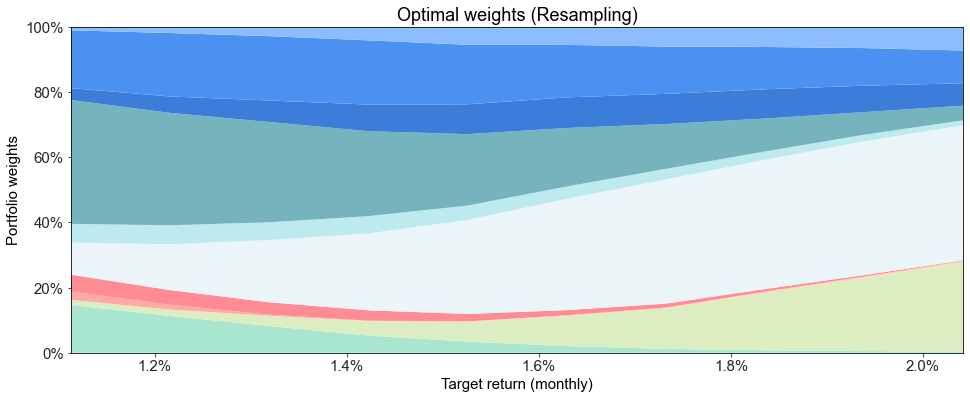

In [238]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(mu_targets, optimal_port_resampled_weights.T);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Target return (monthly)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights (Resampling)");

The method definitely results in more diversified portfolios!

# References

## Articles


[Michaud (1989), "The Markowitz Optimization Enigma: Is 'Optimized' Optimal?"](https://www.jstor.org/stable/4479185)

[Ledoit and Wolf (2004), "A well-conditioned estimator for large-dimensional covariance matrices"](https://www.sciencedirect.com/science/article/pii/S0047259X03000964)

[Jagannathan and Ma (2003), "Risk Reduction in Large Portfolios: Why Imposing the Wrong Constraints Helps"](https://www.jstor.org/stable/3648224)

[Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778)

[Tu and Zhou (2011), "Markowitz meets Talmud: A combination of sophisticated and naive diversification strategies"](https://www.sciencedirect.com/science/article/abs/pii/S0304405X10001893)


## Books

[Riccardo Rebonato and Alexander Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117)

[Ignazio Basile and Pierpaolo Ferrari (2016), "Asset Management and Institutional Investors"](https://link.springer.com/book/10.1007/978-3-319-32796-9)

[Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)

